# Audio MNIST
### RNN
#### 20213013 김어진


## 1. 데이터 분석

#### Audio MNIST 데이터셋 특징
- 목표: 음성 신호를 통해 0부터 9까지의 숫자를 인식하는 모델을 훈련.
- 형태: 각 숫자(0~9) 음성 파일은 WAV 형식으로 저장되어 있습니다. 각 음성 파일은 숫자를 발음한 오디오 클립.
- 샘플: 각 오디오 파일은 고유한 숫자 음성을 포함하고 있으며, 일반적으로 각 숫자에 대해 여러 샘플이 존재.

#### 구성 요소
- 샘플링 레이트: 일반적으로 음성 데이터는 일정한 샘플링 레이트. Audio MNIST의 경우, 보통 16kHz(16,000 샘플/초) 샘플링 레이트로 저장.
- 길이: 각 오디오 클립의 길이는 일정하지 않으며, 대체로 몇 백 밀리초 정도.
레이블: 각 음성 파일은 해당 숫자를 레이블(0~9)화한 음성.

#### waveform / mel-spectrogram
- waveform: 오디오 신호의 시간 영역 표현. 시간에 따른 음압의 변화를 시각화.
- mel-spectrogram: 주파수 영역 표현. 음성 신호를 주파수 대역으로 분해하고, 각 주파수 대역의 에너지 크기를 시각화.

#### 6가지 모델 구성
- Waveform + RNN
- Waveform + LSTM
- Waveform + GRU
- Mel-Spectrogram + RNN
- Mel-Spectrogram + LSTM
- Mel-Spectrogram + GRU

## 데이터 로드


In [1]:
# 데이터 불러오기
import torch # type: ignore
import matplotlib.pyplot as plt # type: ignore
'''    - 샘플: 각 오디오 파일은 고유한 숫자 음성을 포함하고 있으며, 일반적으로 각 숫자에 대해 여러 샘플이 존재.

    #### 구성 요소
    - 샘플링 레이트: 일반적으로 음성 데이터는 일정한 샘플링 레이트. Audio MNIST의 경우, 보통 16kHz(16,000 샘플/초) 샘플링 레이트로 저장.'''

<class 'torch.utils.data.dataset.TensorDataset'>
30000


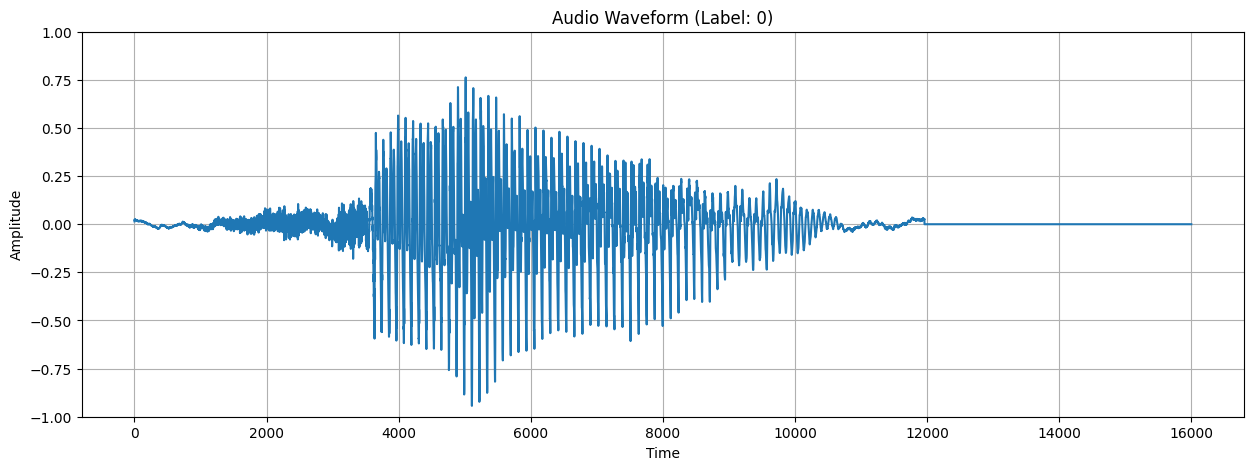

증폭된 파형 데이터 최소값: -0.9435357451438904
증폭된 파형 데이터 최대값: 0.7628443837165833


In [2]:
# waveform 시각화
import matplotlib.pyplot as plt
import numpy as np

# 데이터 구조 확인
print(type(audio_data))  # 데이터 타입 확인
print(len(audio_data))   # 데이터셋의 길이 확인

# 첫 번째 데이터 샘플 접근
first_sample = audio_data[0]
waveform = first_sample[0]
label = first_sample[1]

# 데이터 증폭 (예: 50배)
amplification = 50
waveform_amplified = waveform * amplification

# Waveform 시각화
plt.figure(figsize=(15, 5))
plt.plot(waveform_amplified.numpy().flatten())  # flatten()으로 1차원으로 변환
plt.title(f"Audio Waveform (Label: {label})")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.ylim(-1, 1)  # y축 범위는 그대로 유지
plt.show()

# 데이터 정보 출력
print("증폭된 파형 데이터 최소값:", waveform_amplified.min().item())
print("증폭된 파형 데이터 최대값:", waveform_amplified.max().item())

In [3]:
import torchaudio # type: ignore
import IPython.display as ipd # type: ignore

# 첫 번째 데이터 샘플 접근
first_sample = audio_data[0]
waveform = first_sample[0]

# 파일로 저장하기
torchaudio.save('sample_audio.wav', waveform, sample_rate=16000)

## 데이터 전처리

In [4]:
print(0)

0


: 

## RNN 모델

## 손실 함수

## 모델 학습

## 학습 평가

## 예측 및 결과